In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics as skm
from time import *
from tqdm import tqdm
from torch_geometric.utils import to_dense_adj
import os
import torch
from sgl import LearnGraphTopolgy
os.getcwd()
dataset = os.path.join(os.getcwd(),'Cora')
dataset
from torch_geometric.datasets import Planetoid
dataset= Planetoid(root=dataset, name='Cora')
x = dataset[0].x.detach().cpu().numpy()
labels = dataset[0].y
NO_OF_CLASSES =  len(set(np.array(dataset[0].y)))






adj = to_dense_adj(dataset[0].edge_index)
adj = adj[0]
labels = dataset[0].y
labels = labels.numpy()

X = dataset[0].x
X = X.to_dense()
N = X.shape[0]
NO_OF_CLASSES =  len(set(np.array(dataset[0].y)))

print(X.shape, adj.shape)

nn = int(1*N)
X = X[:nn,:]
adj = adj[:nn,:nn]
A = adj[:nn,:nn]
AT= torch.transpose(A,0,1)
labels = labels[:nn]
print(dataset[0])


def get_laplacian(adj):
    b=torch.ones(adj.shape[0])
    return torch.diag(adj@b)-adj

theta = get_laplacian(adj)
print(theta.shape)

torch.Size([2708, 1433]) torch.Size([2708, 2708])
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
torch.Size([2708, 2708])


In [2]:
X.shape

torch.Size([2708, 1433])

In [3]:
S = np.dot(X, X.T)
Sinv = np.linalg.pinv(S)
Sinv.shape[1]

2708

In [4]:
S = np.dot(X, X.T)

# estimate underlying graph
sgl = LearnGraphTopolgy(S, maxiter=250, record_objective = True, record_weights = True)
# graph = sgl.learn_k_component_graph(w0 = 'qp', k=5, beta=1 )
graph = sgl.learn_k_component_graph(k=7, beta=5 )



100%|██████████████████████████████████████████████████████████████████████████████| 250/250 [1:19:59<00:00, 19.20s/it]


In [20]:
import networkx as nx
A = graph['adjacency']
G = nx.from_numpy_matrix(A)
print('Graph statistics:')
print('Nodes: ', G.number_of_nodes(), 'Edges: ', G.number_of_edges() )

Graph statistics:
Nodes:  2708 Edges:  661


In [39]:


filename='CORA_k_comp_adj_matrix.txt'
np.savetxt(filename,A)

In [33]:
L = graph['laplacian']
filename='CORA_k_comp_lap_matrix.txt'
np.savetxt(filename,L)
def nb_connected_component(L):
    return np.sum(np.linalg.eigh(L)[0]<10**-12)
nb_connected_component(L)

2495

In [19]:
from scipy import sparse
from random import sample
adj2=graph['adjacency']
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(X.shape[1], 64)
        self.conv2 = GCNConv(64, NO_OF_CLASSES)

    def reset_parameters(self):
        self.conv1.reset_parameters()
        self.conv2.reset_parameters()

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)
    
    
####### NO output layer is written
NO_OF_NODES = X.shape[0]
Wc=adj2
Wc=sparse.csr_matrix(Wc)
Wc = Wc.tocoo()
row = torch.from_numpy(Wc.row).to(torch.long)
col = torch.from_numpy(Wc.col).to(torch.long)
edge_index_coarsen2 = torch.stack([row, col], dim=0)
edge_weight = torch.from_numpy(Wc.data)

device = torch.device('cpu')
Y = labels
labels_coarse=torch.Tensor(Y).type(torch.long)
Wc=Wc.toarray()
model=Net().to(device)
device = torch.device('cpu')
lr=0.1
decay=0.01
features = torch.Tensor(X)
try:
  X=np.array(features.todense())
except:
  X = np.array(features)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
p = X.shape[0]
x=range(0,int(p*0.9))
xx=range(int(p*0.9),p)
from datetime import datetime
def train():
    model.train()
    optimizer.zero_grad()
    out = model(torch.Tensor(X).to(device),edge_index_coarsen2)
    loss = F.nll_loss(out[x], labels_coarse[x])
    loss.backward()
    optimizer.step()
    return loss
now1 = datetime.now()
losses=[]
for epoch in range(500):
    loss=train()
    losses.append(loss)
    if(epoch%10==0):
        print(f'Epoch: {epoch:03d},loss: {loss:.4f}')
now2 = datetime.now()
pred=model(torch.Tensor(X).to(device),edge_index_coarsen2).argmax(dim=1)

def train_accuracy():
    model.eval()
    correct = (pred[xx] == labels_coarse[xx]).sum()
    acc = int(correct) /len(xx)
    return acc

zz=sample(range(0, int(NO_OF_NODES)), NO_OF_NODES)
Wc=sparse.csr_matrix(adj2)
Wc = Wc.tocoo()
row = torch.from_numpy(Wc.row).to(torch.long)
col = torch.from_numpy(Wc.col).to(torch.long)
edge_index_coarsen = torch.stack([row, col], dim=0)
edge_weight = torch.from_numpy(Wc.data)
pred=model(torch.Tensor(X),edge_index_coarsen).argmax(dim=1)
pred=np.array(pred)
correct =(pred[xx]==labels[xx]).sum()
acc=int(correct)/len(xx)
acc

Epoch: 000,loss: 1.9606
Epoch: 010,loss: 0.7307
Epoch: 020,loss: 0.6100
Epoch: 030,loss: 0.5862
Epoch: 040,loss: 0.5601
Epoch: 050,loss: 0.5634
Epoch: 060,loss: 0.5406
Epoch: 070,loss: 0.5412
Epoch: 080,loss: 0.5527
Epoch: 090,loss: 0.5193
Epoch: 100,loss: 0.5688
Epoch: 110,loss: 0.5454
Epoch: 120,loss: 0.5342
Epoch: 130,loss: 0.5783
Epoch: 140,loss: 0.5532
Epoch: 150,loss: 0.5595
Epoch: 160,loss: 0.5148
Epoch: 170,loss: 0.5394
Epoch: 180,loss: 0.5238
Epoch: 190,loss: 0.5878
Epoch: 200,loss: 0.5981
Epoch: 210,loss: 0.5888
Epoch: 220,loss: 0.5755
Epoch: 230,loss: 0.5295
Epoch: 240,loss: 0.5630
Epoch: 250,loss: 0.5602
Epoch: 260,loss: 0.5406
Epoch: 270,loss: 0.5404
Epoch: 280,loss: 0.5314
Epoch: 290,loss: 0.5335
Epoch: 300,loss: 0.5303
Epoch: 310,loss: 0.5663
Epoch: 320,loss: 0.5283
Epoch: 330,loss: 0.5343
Epoch: 340,loss: 0.5812
Epoch: 350,loss: 0.5610
Epoch: 360,loss: 0.5339
Epoch: 370,loss: 0.5333
Epoch: 380,loss: 0.5494
Epoch: 390,loss: 0.5635
Epoch: 400,loss: 0.5469
Epoch: 410,loss:

0.7712177121771218

(350, 2)
(350, 350)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:43<00:00,  2.91it/s]


Objective:  -520.8800159244779
Graph statistics:
Nodes:  350 Edges:  636


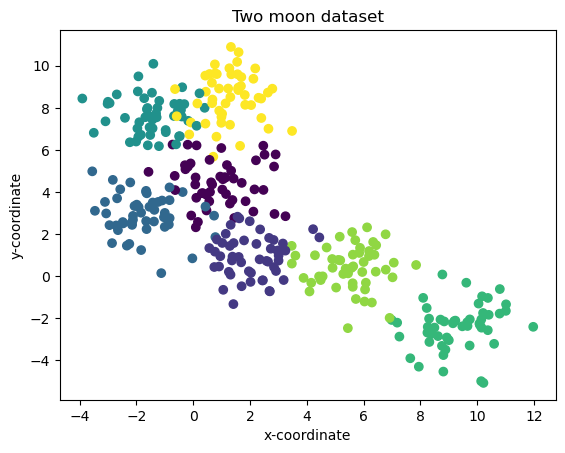

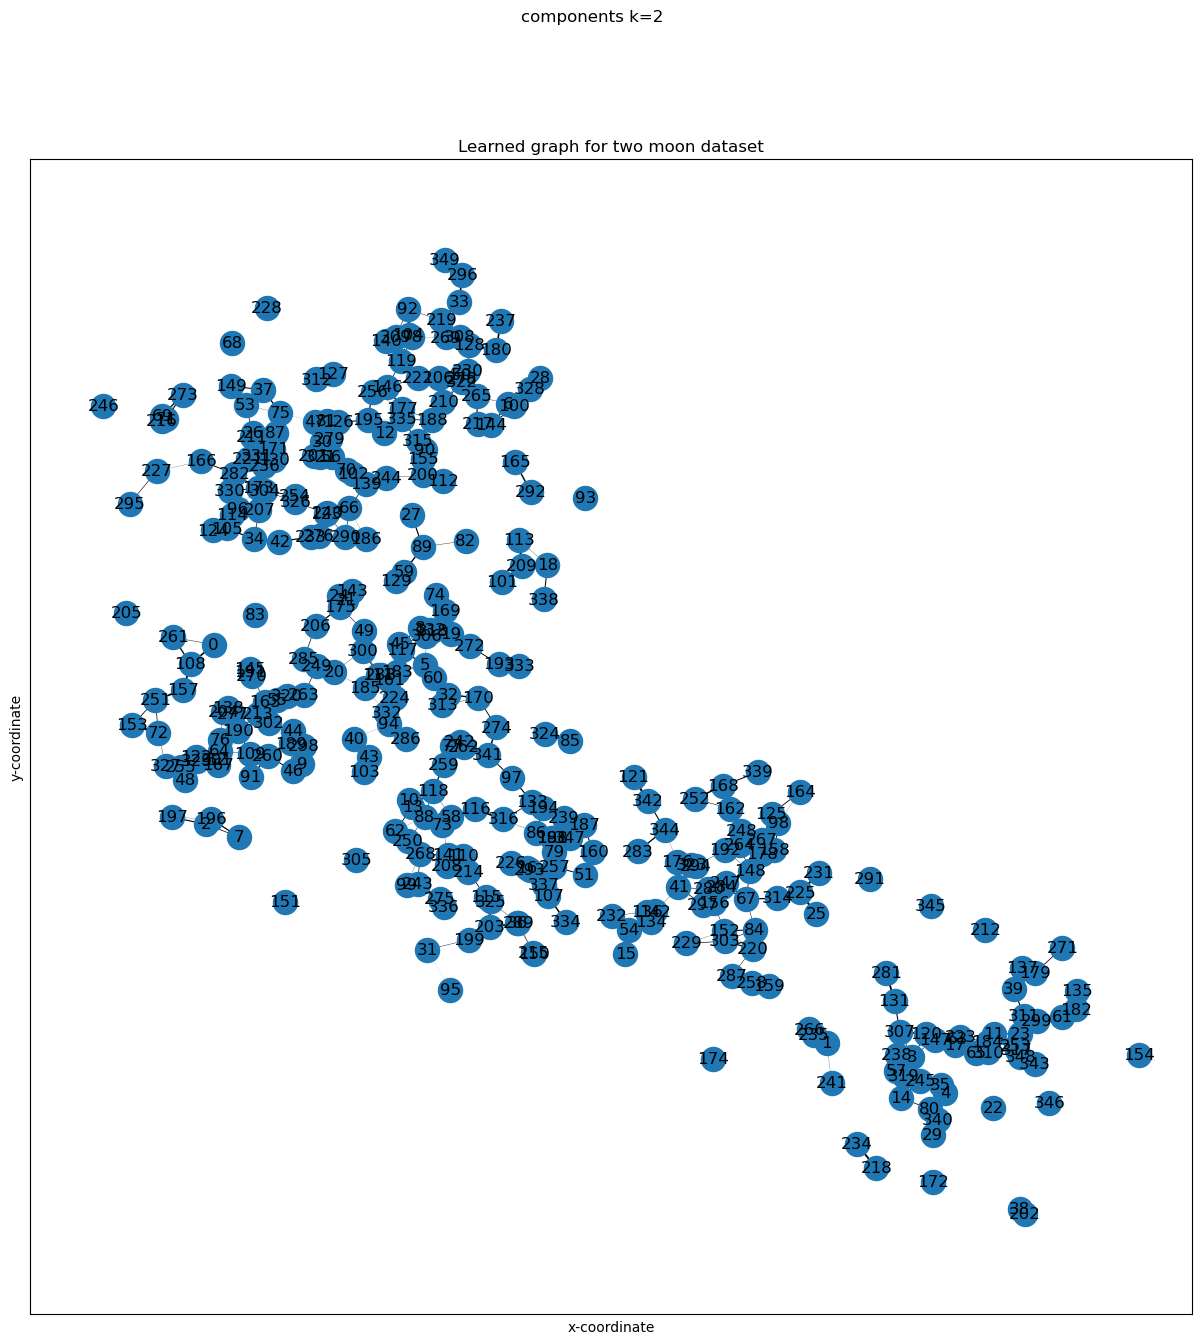

In [25]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sgl import LearnGraphTopolgy

plots_dir = './plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

'''Visual results on two moon dataset 

'''
np.random.seed(0)
n = 50  # number of nodes per cluster
k = 7   # number of components
# X, y = make_moons(n_samples=n*k, noise=.05, shuffle=True)


X, y = make_blobs(n_samples=n*k, centers=k, n_features=2, random_state=0)

print(X.shape)
# dict to store position of nodes
pos = {}
for i in range(n*k):
    pos[i] = X[i]
# Visualization of original data
fig = plt.figure()
plt.scatter(X[:,0], X[:,1], c=y )
plt.title("Two moon dataset")
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
fig.savefig('plots/two_moon_dataset.eps', format='eps')
fig.savefig('plots/two_moon_dataset.png')

# compute sample correlation matrix
S = np.dot(X, X.T)
print(S.shape)

# estimate underlying graph
sgl = LearnGraphTopolgy(S, maxiter=1000, record_objective = True, record_weights = True)
graph = sgl.learn_k_component_graph(k=10, beta=0.1 )
# graph1 = sgl.learn_bipartite_graph()

objective = graph['obj_fun']
print('Objective: ', min(objective))

# build network
A = graph['adjacency']
G = nx.from_numpy_matrix(A)
print('Graph statistics:')
print('Nodes: ', G.number_of_nodes(), 'Edges: ', G.number_of_edges() )

# normalize edge weights to plot edges strength
all_weights = []
for (node1,node2,data) in G.edges(data=True):
    all_weights.append(data['weight'])
max_weight = max(all_weights)
norm_weights = [3* w / max_weight for w in all_weights]
norm_weights = norm_weights

# plot graph
fig = plt.figure(figsize=(15,15)) 
nx.draw_networkx(G,pos, width=norm_weights)
plt.title("Learned graph for two moon dataset")
plt.suptitle('components k=2')
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
filename = 'plots/learned_graph_k='+ str(k) +'.eps'
png_filename = 'plots/learned_graph_k='+ str(k) +'.png'
fig.savefig(filename, format='eps')
fig.savefig(png_filename,)

In [26]:
def nb_connected_component(L):
    return np.sum(np.linalg.eigh(L)[0]<10**-12)

In [27]:
L = graph['laplacian']

In [28]:
nb_connected_component(L)

28

In [30]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
graph3 = csr_matrix(A)

In [34]:
n_components, labels = connected_components(csgraph=graph3, directed=False, return_labels=True)
n_components

28

In [29]:
import math
def L(w):
    '''Usage: print(L([1,0,1]))
    
    '''
    k = len(w)
    n = int(0.5*(1+ math.sqrt(1+8*k)))
    print("n",n)
    Lw = np.zeros((n,n))
    print("Lw1:",Lw)
    k=0
    for i in range(0, n):
        for j in range(i+1,n):
            Lw[i][j] = -w[k]
            k = k + 1
        # print(Lw) 
    Lw = Lw + Lw.T
    row,col = np.diag_indices_from(Lw)
    print("row",row)
    print(Lw)
    Lw[row,col] = -Lw.sum(axis=1)
    return Lw

In [30]:
print(L([1,0,1]))
 

n 3
Lw1: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
row [0 1 2]
[[ 0. -1.  0.]
 [-1.  0. -1.]
 [ 0. -1.  0.]]
[[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]


In [25]:
math.sqrt(1+8*7)

7.54983443527075

In [43]:
def Lstar(M):
    N = M.shape[1]
    k = int( 0.5*N*(N-1))
    w = np.zeros(k)
    j=0
    l=1
    for i in range(0,k):
        w[i] = M[j][j] + M[l][l] -(M[l][j] + M[j][l])
        if l==(N-1):
            j = j+1
            l = j+1
        else:
            l = l+1
    return w

In [46]:
Fuck=[ 1, -1 , 0]

In [47]:
Lstar(Fuck)

AttributeError: 'list' object has no attribute 'shape'